In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Preprocessing

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
print("image shape:", train_images.shape, test_images.shape)
print("labels shape:", train_labels.shape, test_labels.shape)

image shape: (60000, 28, 28) (10000, 28, 28)
labels shape: (60000,) (10000,)


In [4]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

In [5]:
images = np.concatenate([train_images, test_images], axis=0)
labels = np.concatenate([train_labels, test_labels], axis=0)

In [6]:
print("image shape:", images.shape)
print("labels shape:", labels.shape)

image shape: (70000, 28, 28)
labels shape: (70000,)


In [7]:
filters = np.where((labels == 4) | (labels == 5))
images_filtered = images[filters]
labels_filtered = labels[filters]

In [8]:
print("image shape:", images_filtered.shape)
print("labels shape:", labels_filtered.shape)

image shape: (14000, 28, 28)
labels shape: (14000,)


In [9]:
adict = {4:0, 5:1}
labels_filtered = np.vectorize(adict.get)(labels_filtered)
labels_filtered

array([1, 1, 1, ..., 0, 1, 1])

In [10]:
n = images_filtered.shape[0]
q80 = int(0.8 * n)
q20 = int(0.2 * n)

train_images, train_labels = images_filtered[:q80], labels_filtered[:q80]
test_images, test_labels = images_filtered[q80:], labels_filtered[q80:]

In [11]:
print("train shape:", train_images.shape)
print("test shape:", test_images.shape)

train shape: (11200, 28, 28)
test shape: (2800, 28, 28)


# Show example from data

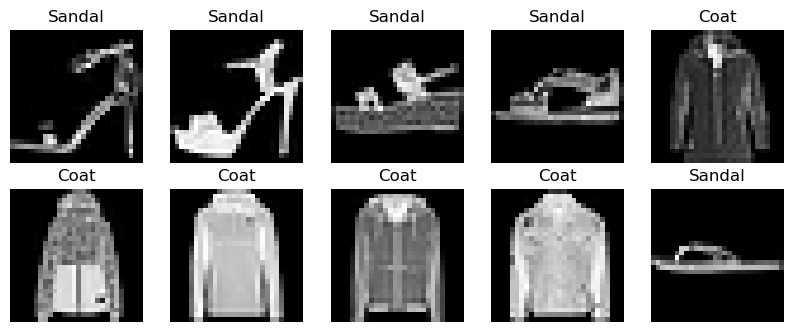

In [12]:
def display_sample_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

class_names = {0: "Coat", 1: "Sandal"}

display_sample_images(train_images, train_labels, class_names)
plt.show()

In [13]:
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)
print("train shape:", train_images.shape)
print("test shape:", test_images.shape)

train shape: (11200, 28, 28, 1)
test shape: (2800, 28, 28, 1)


In [14]:
def build_generator(latent_dim, num_classes):
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(latent_dim + num_classes,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(28 * 28, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

In [15]:
def build_discriminator(num_classes):
    img_size = 28 * 28
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(img_size + num_classes,)))
    model.add(layers.Dense(512, activation='leaky_relu'))
    model.add(layers.Dense(1024, activation='leaky_relu'))
    model.add(layers.Dense(1024, activation='leaky_relu'))
    model.add(layers.Dense(512, activation='leaky_relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [16]:
latent_dim = 100
num_classes = 2
batch_size = 100

In [17]:
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(num_classes)

In [18]:
def combine_noise_and_labels(noise, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    return tf.concat([noise, label_embedding], axis=1)

In [19]:
def combine_images_and_labels(images, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    images_flatten = tf.reshape(images, [images.shape[0], -1])
    return tf.concat([images_flatten, label_embedding], axis=1)

In [20]:
def display_images(generator, noise, labels, epoch, num_examples=5):
    generated_images = generator.predict(combine_noise_and_labels(noise, labels, num_classes), verbose=0)
    generated_images = (generated_images + 1) / 2.0  # Scaling to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

In [21]:
crossentropy = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)

In [22]:
def discriminator_training_step(real_images_with_labels, fake_images_with_labels):
    with tf.GradientTape() as tape:
        real_output = discriminator(real_images_with_labels, training=True)
        fake_output = discriminator(fake_images_with_labels, training=True)

        d_loss_real = crossentropy(tf.ones_like(real_output), real_output)
        d_loss_fake = crossentropy(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    real_accuracy = tf.reduce_mean(tf.cast(real_output >= 0.5, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    d_accuracy = 0.5 * (real_accuracy + fake_accuracy)

    return d_loss, d_accuracy

In [23]:
def generator_training_step(noise, fake_labels):
    misleading_labels = tf.ones([batch_size, 1])

    with tf.GradientTape() as tape:
        fake_images = generator(combine_noise_and_labels(noise, fake_labels, num_classes), training=True)
        fake_output = discriminator(combine_images_and_labels(fake_images, fake_labels, num_classes), training=True)

        g_loss = crossentropy(misleading_labels, fake_output)

    grads = tape.gradient(g_loss, generator.trainable_variables)
    optimizer2.apply_gradients(zip(grads, generator.trainable_variables))

    return g_loss

In [24]:
@tf.function
def train_step(real_images, real_labels):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, latent_dim])
    fake_labels = tf.random.uniform([batch_size], minval=0, maxval=num_classes, dtype=tf.int32)

    fake_images = generator(combine_noise_and_labels(noise, fake_labels, num_classes))

    combined_labels = tf.concat([tf.cast(real_labels, tf.int32), fake_labels], axis=0)
    combined_images = tf.concat([real_images, fake_images], axis=0)

    # Combine images and labels for discriminator
    real_images_with_labels = combine_images_and_labels(real_images, tf.cast(real_labels, tf.int32), num_classes)
    fake_images_with_labels = combine_images_and_labels(fake_images, fake_labels, num_classes)
    combined_images_with_labels = tf.concat([real_images_with_labels, fake_images_with_labels], axis=0)

    # Discriminator training
    d_loss, d_accuracy = discriminator_training_step(real_images_with_labels, fake_images_with_labels)

    # Generator training
    noise = tf.random.normal([batch_size, latent_dim])
    g_loss = generator_training_step(noise, fake_labels)

    return d_loss, g_loss, d_accuracy

In [25]:
def train(dataset, epochs, save_interval=10):
    noise = np.random.normal(0, 1, (5, latent_dim))
    labels = np.random.randint(0, num_classes, 5)
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            d_loss, g_loss, d_acc = train_step(image_batch, label_batch)

        print(f'Epoch {epoch+1}, D Loss: {d_loss.numpy()},D Acc: {d_acc.numpy()} G Loss: {g_loss.numpy()}')

        if (epoch + 1) % save_interval == 0:
            display_images(generator, noise, labels, epoch + 1)

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

Epoch 1, D Loss: 1.1082080602645874,D Acc: 0.5149999856948853 G Loss: 1.9250744581222534
Epoch 2, D Loss: 1.0083212852478027,D Acc: 0.7899999618530273 G Loss: 1.3896372318267822
Epoch 3, D Loss: 1.050330400466919,D Acc: 0.8199999928474426 G Loss: 1.6356420516967773
Epoch 4, D Loss: 0.5055447816848755,D Acc: 0.8949999809265137 G Loss: 1.478052020072937
Epoch 5, D Loss: 1.1510568857192993,D Acc: 0.6050000190734863 G Loss: 2.011157512664795
Epoch 6, D Loss: 0.8116731643676758,D Acc: 0.8849999904632568 G Loss: 0.8072034120559692
Epoch 7, D Loss: 1.2496144771575928,D Acc: 0.42500001192092896 G Loss: 0.8520379662513733
Epoch 8, D Loss: 1.506301999092102,D Acc: 0.4950000047683716 G Loss: 2.9035375118255615
Epoch 9, D Loss: 0.9124667048454285,D Acc: 0.7049999833106995 G Loss: 1.0727031230926514
Epoch 10, D Loss: 0.9237372875213623,D Acc: 0.8149999976158142 G Loss: 1.120225191116333


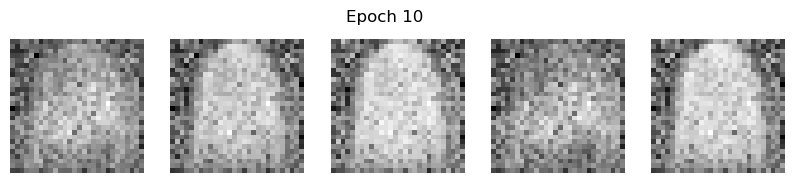

Epoch 11, D Loss: 0.9982043504714966,D Acc: 0.8250000476837158 G Loss: 1.2408545017242432
Epoch 12, D Loss: 1.167824387550354,D Acc: 0.7400000095367432 G Loss: 0.9441727995872498
Epoch 13, D Loss: 1.2558997869491577,D Acc: 0.7250000238418579 G Loss: 0.9626354575157166
Epoch 14, D Loss: 1.2207131385803223,D Acc: 0.5699999928474426 G Loss: 0.7783039212226868
Epoch 15, D Loss: 1.4863977432250977,D Acc: 0.48500001430511475 G Loss: 0.7819459438323975
Epoch 16, D Loss: 1.3031450510025024,D Acc: 0.6399999856948853 G Loss: 0.858058512210846
Epoch 17, D Loss: 1.219212293624878,D Acc: 0.6499999761581421 G Loss: 1.151931643486023
Epoch 18, D Loss: 1.3556041717529297,D Acc: 0.5099999904632568 G Loss: 0.8411856889724731
Epoch 19, D Loss: 1.360532283782959,D Acc: 0.5299999713897705 G Loss: 0.7111721634864807
Epoch 20, D Loss: 1.2022228240966797,D Acc: 0.6349999904632568 G Loss: 0.8417696356773376


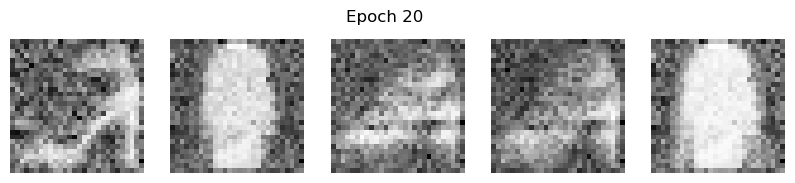

Epoch 21, D Loss: 1.2499072551727295,D Acc: 0.625 G Loss: 0.9402234554290771
Epoch 22, D Loss: 1.1378250122070312,D Acc: 0.6499999761581421 G Loss: 1.0503484010696411
Epoch 23, D Loss: 1.3845250606536865,D Acc: 0.5099999904632568 G Loss: 1.0845191478729248
Epoch 24, D Loss: 1.180053472518921,D Acc: 0.6649999618530273 G Loss: 0.8239989280700684
Epoch 25, D Loss: 1.296562671661377,D Acc: 0.6100000143051147 G Loss: 1.117435097694397
Epoch 26, D Loss: 1.2002174854278564,D Acc: 0.6050000190734863 G Loss: 1.1258269548416138
Epoch 27, D Loss: 1.2570717334747314,D Acc: 0.6100000143051147 G Loss: 0.9474667310714722
Epoch 28, D Loss: 1.2709254026412964,D Acc: 0.5899999737739563 G Loss: 1.0241442918777466
Epoch 29, D Loss: 1.3384666442871094,D Acc: 0.5850000381469727 G Loss: 0.8150596618652344
Epoch 30, D Loss: 1.1399816274642944,D Acc: 0.6949999928474426 G Loss: 0.9134801030158997


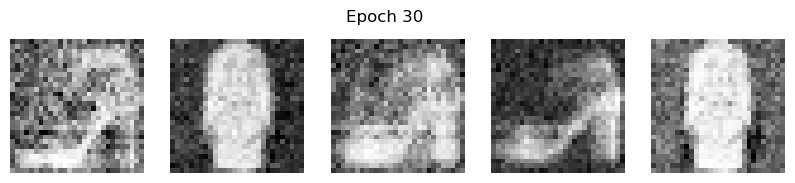

Epoch 31, D Loss: 1.2446190118789673,D Acc: 0.5450000166893005 G Loss: 0.9076392650604248
Epoch 32, D Loss: 1.2884466648101807,D Acc: 0.6000000238418579 G Loss: 1.027243971824646
Epoch 33, D Loss: 1.3317673206329346,D Acc: 0.49000000953674316 G Loss: 1.1180295944213867
Epoch 34, D Loss: 1.1280994415283203,D Acc: 0.6649999618530273 G Loss: 1.0407978296279907
Epoch 35, D Loss: 1.2938270568847656,D Acc: 0.5999999642372131 G Loss: 0.7586585283279419
Epoch 36, D Loss: 1.3070178031921387,D Acc: 0.6200000047683716 G Loss: 1.1256657838821411
Epoch 37, D Loss: 1.2450225353240967,D Acc: 0.6100000143051147 G Loss: 1.083290696144104
Epoch 38, D Loss: 1.331443428993225,D Acc: 0.6050000190734863 G Loss: 0.9821540117263794
Epoch 39, D Loss: 1.2473214864730835,D Acc: 0.574999988079071 G Loss: 1.0701192617416382
Epoch 40, D Loss: 1.2593404054641724,D Acc: 0.5400000214576721 G Loss: 0.9578083753585815


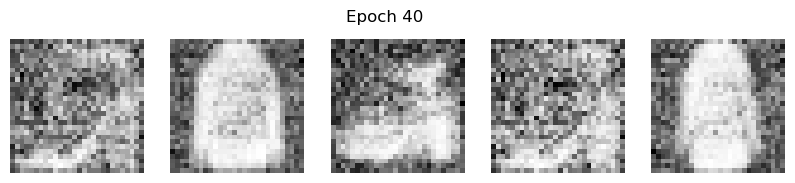

Epoch 41, D Loss: 1.1003332138061523,D Acc: 0.6349999904632568 G Loss: 1.404894232749939
Epoch 42, D Loss: 1.1949834823608398,D Acc: 0.6200000047683716 G Loss: 0.9342474341392517
Epoch 43, D Loss: 1.1201121807098389,D Acc: 0.7099999785423279 G Loss: 0.7619522213935852
Epoch 44, D Loss: 1.1617834568023682,D Acc: 0.6599999666213989 G Loss: 1.1536880731582642
Epoch 45, D Loss: 1.1621623039245605,D Acc: 0.6449999809265137 G Loss: 0.9041985273361206
Epoch 46, D Loss: 1.2694604396820068,D Acc: 0.6100000143051147 G Loss: 1.0251216888427734
Epoch 47, D Loss: 1.3081974983215332,D Acc: 0.6000000238418579 G Loss: 0.796777606010437
Epoch 48, D Loss: 1.2855794429779053,D Acc: 0.6000000238418579 G Loss: 0.9777576923370361
Epoch 49, D Loss: 1.2477452754974365,D Acc: 0.6100000143051147 G Loss: 1.3243736028671265
Epoch 50, D Loss: 1.1403660774230957,D Acc: 0.6649999618530273 G Loss: 1.1340625286102295


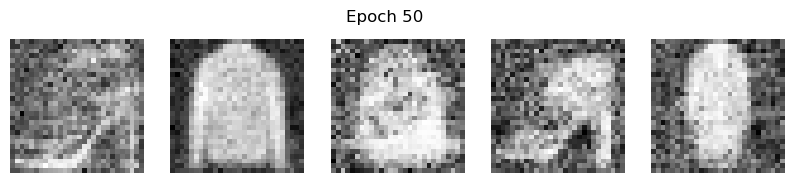

Epoch 51, D Loss: 1.2046507596969604,D Acc: 0.6850000023841858 G Loss: 1.255037546157837
Epoch 52, D Loss: 1.2952334880828857,D Acc: 0.6499999761581421 G Loss: 0.8737785816192627
Epoch 53, D Loss: 1.247094988822937,D Acc: 0.5800000429153442 G Loss: 0.9630557894706726
Epoch 54, D Loss: 1.1484804153442383,D Acc: 0.7049999833106995 G Loss: 1.1855424642562866
Epoch 55, D Loss: 1.297421932220459,D Acc: 0.6399999856948853 G Loss: 0.841113805770874
Epoch 56, D Loss: 1.1871070861816406,D Acc: 0.6650000214576721 G Loss: 1.1259721517562866
Epoch 57, D Loss: 1.1806128025054932,D Acc: 0.6399999856948853 G Loss: 0.9602718949317932
Epoch 58, D Loss: 1.12727689743042,D Acc: 0.6499999761581421 G Loss: 1.1789897680282593
Epoch 59, D Loss: 1.2233705520629883,D Acc: 0.5950000286102295 G Loss: 0.8045061826705933
Epoch 60, D Loss: 1.299246907234192,D Acc: 0.5799999833106995 G Loss: 0.9262284636497498


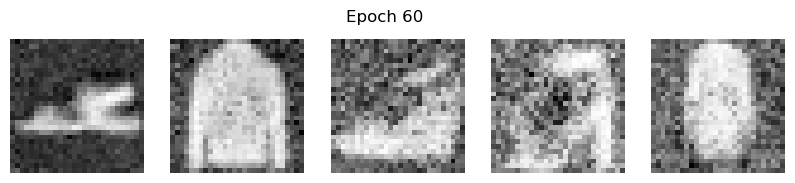

Epoch 61, D Loss: 1.2967007160186768,D Acc: 0.6150000095367432 G Loss: 1.247678279876709
Epoch 62, D Loss: 1.215306282043457,D Acc: 0.675000011920929 G Loss: 1.052371621131897
Epoch 63, D Loss: 1.3577611446380615,D Acc: 0.6299999952316284 G Loss: 1.4294872283935547
Epoch 64, D Loss: 1.1734545230865479,D Acc: 0.6200000047683716 G Loss: 1.0013281106948853
Epoch 65, D Loss: 1.2308725118637085,D Acc: 0.6349999904632568 G Loss: 1.4043235778808594
Epoch 66, D Loss: 1.0876574516296387,D Acc: 0.6949999928474426 G Loss: 1.368956446647644
Epoch 67, D Loss: 1.1512229442596436,D Acc: 0.6499999761581421 G Loss: 1.1158063411712646
Epoch 68, D Loss: 1.094200849533081,D Acc: 0.6949999928474426 G Loss: 1.1544103622436523
Epoch 69, D Loss: 1.1225998401641846,D Acc: 0.6850000023841858 G Loss: 1.1869781017303467
Epoch 70, D Loss: 0.9528493881225586,D Acc: 0.7400000095367432 G Loss: 1.505355954170227


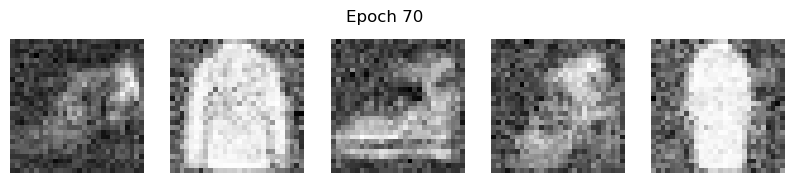

Epoch 71, D Loss: 1.119779348373413,D Acc: 0.6399999856948853 G Loss: 1.1226266622543335
Epoch 72, D Loss: 1.1205369234085083,D Acc: 0.6649999618530273 G Loss: 1.1458197832107544
Epoch 73, D Loss: 1.0546950101852417,D Acc: 0.75 G Loss: 1.1186829805374146
Epoch 74, D Loss: 1.2365310192108154,D Acc: 0.6200000047683716 G Loss: 0.8102769255638123
Epoch 75, D Loss: 1.1737208366394043,D Acc: 0.675000011920929 G Loss: 1.1619137525558472
Epoch 76, D Loss: 1.0858440399169922,D Acc: 0.699999988079071 G Loss: 1.1445289850234985
Epoch 77, D Loss: 1.049255132675171,D Acc: 0.6950000524520874 G Loss: 1.3945518732070923
Epoch 78, D Loss: 1.1789653301239014,D Acc: 0.6599999666213989 G Loss: 2.0135061740875244
Epoch 79, D Loss: 0.9899061918258667,D Acc: 0.7549999952316284 G Loss: 1.2629119157791138
Epoch 80, D Loss: 1.0086090564727783,D Acc: 0.75 G Loss: 1.3451429605484009


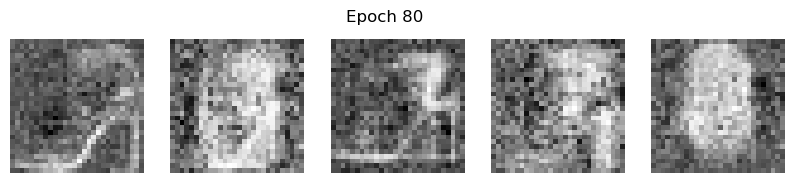

Epoch 81, D Loss: 1.2274335622787476,D Acc: 0.6699999570846558 G Loss: 1.2724382877349854
Epoch 82, D Loss: 0.9987316131591797,D Acc: 0.7150000333786011 G Loss: 1.2629892826080322
Epoch 83, D Loss: 1.1193604469299316,D Acc: 0.6200000047683716 G Loss: 1.4258288145065308
Epoch 84, D Loss: 0.9312427043914795,D Acc: 0.7749999761581421 G Loss: 1.5413131713867188
Epoch 85, D Loss: 1.1259417533874512,D Acc: 0.7099999785423279 G Loss: 1.1438617706298828
Epoch 86, D Loss: 1.0963865518569946,D Acc: 0.6850000023841858 G Loss: 1.2446742057800293
Epoch 87, D Loss: 0.9122555255889893,D Acc: 0.7350000143051147 G Loss: 1.4487271308898926
Epoch 88, D Loss: 0.8367086052894592,D Acc: 0.8149999976158142 G Loss: 1.6979312896728516
Epoch 89, D Loss: 0.8422486782073975,D Acc: 0.800000011920929 G Loss: 1.4451754093170166
Epoch 90, D Loss: 1.084928274154663,D Acc: 0.7350000143051147 G Loss: 1.440592646598816


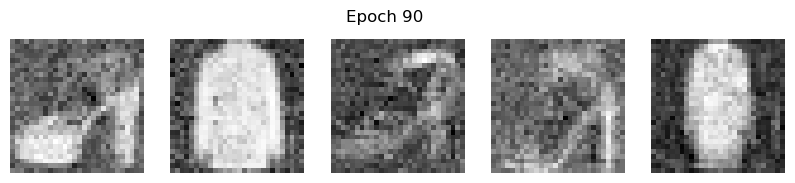

Epoch 91, D Loss: 0.96705162525177,D Acc: 0.7400000095367432 G Loss: 1.3251992464065552
Epoch 92, D Loss: 0.9813803434371948,D Acc: 0.7049999833106995 G Loss: 1.6724365949630737
Epoch 93, D Loss: 0.8457967042922974,D Acc: 0.7699999809265137 G Loss: 1.6149975061416626
Epoch 94, D Loss: 0.9833002686500549,D Acc: 0.7300000190734863 G Loss: 1.894265055656433
Epoch 95, D Loss: 0.8121036291122437,D Acc: 0.75 G Loss: 2.096320390701294
Epoch 96, D Loss: 0.7692344188690186,D Acc: 0.7749999761581421 G Loss: 1.8581889867782593
Epoch 97, D Loss: 1.0385210514068604,D Acc: 0.7049999833106995 G Loss: 1.4576363563537598
Epoch 98, D Loss: 1.0895562171936035,D Acc: 0.75 G Loss: 1.3282891511917114
Epoch 99, D Loss: 1.190860629081726,D Acc: 0.625 G Loss: 1.8548537492752075
Epoch 100, D Loss: 0.8645871877670288,D Acc: 0.7599999904632568 G Loss: 1.8412903547286987


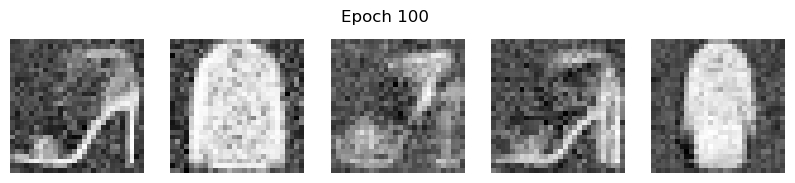

In [27]:
train(train_dataset, epochs=100)

# FID

In [29]:
def to_rgb(images):
    return np.repeat(images, 3, axis=-1)

In [30]:
def get_features(images, model, batch_size=32):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        # Ensure the batch has a channel dimension
        if batch.ndim == 3:
            batch = np.expand_dims(batch, axis=-1)
        batch_rgb = to_rgb(batch)  # Convert to RGB if not already
        batch_resized = tf.image.resize(batch_rgb, (299, 299))
        batch_preprocessed = preprocess_input(batch_resized)
        batch_features = model.predict(batch_preprocessed)
        features.append(batch_features)
    return np.concatenate(features, axis=0)

In [31]:
def compute_fid(real_features, fake_features):
    mean_real = np.mean(real_features, axis=0)
    cov_real = np.cov(real_features, rowvar=False)
    mean_fake = np.mean(fake_features, axis=0)
    cov_fake = np.cov(fake_features, rowvar=False)

    mean_diff_squared = np.sum((mean_real - mean_fake) ** 2.0)
    cov_mean_sqrt = sqrtm(cov_real.dot(cov_fake))

    # Handling imaginary values
    if np.iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real

    fid_value = mean_diff_squared + np.trace(cov_real + cov_fake - 2.0 * cov_mean_sqrt)
    return fid_value

FID=∥μreal​−μfake​∥2+Tr(Σreal​+Σfake​−2(Σreal​Σfake​)1/2)

In [33]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
noise_vector = np.random.normal(0, 1, (test_images.shape[0], latent_dim))
fake_labels = test_labels
fake_images = generator.predict(combine_noise_and_labels(noise_vector, fake_labels, num_classes), verbose=0)
real_features = get_features(test_images, inception_model)
fake_features = get_features(fake_images, inception_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [35]:
fid_score = compute_fid(real_features, fake_features)
print(f'FID score: {fid_score}')

FID score: 0.4972748649084976
